# Blood Glucose Forecasting - BioConscious Deep Learning Challenge
By Rob Bergen

## Introduction:
### This notebook outlines a deep learning model I developed to predict blood glucose levels in diabetics who wear continuous glucose monitors (CGMs). Blood glucose levels are measured every 5 minutes, and heart rate and step count activity are also available through Fitbit devices or iPhone apps.

### In this notebook, I will outline the steps I took to 
    1. Preprocess the data
    2. Train a basic LSTM network
    3. Refine the network
    4. Analyze results

## Importing the data
### The data is made available through .csv files. I import them here into 3 separate data frames and examine the information available to me.

In [77]:
import pandas as pd
import numpy as np
from pandas import read_excel
import xlrd
import matplotlib.pyplot as plt
import itertools
import statsmodels.api as sm
import seaborn as sn
import warnings
warnings.filterwarnings('ignore')

bg = pd.read_csv('Bio Conscious Data Challenge/blood-glucose-data.csv', encoding = 'latin_1')
bg.head()

,point_value(mg/dL),point_timestamp,timezone_offset
0,142,2017-05-15 07:51:22,-700
1,140,2017-05-15 07:56:23,-700
2,138,2017-05-15 08:01:22,-700
3,136,2017-05-15 08:06:22,-700
4,130,2017-05-15 08:11:23,-700


In [2]:
da = pd.read_csv('Bio Conscious Data Challenge/distance-activity-data.csv', encoding = 'latin_1')
da.head()

,point_value(kilometers),point_timestamp,timezone_offset,device
0,0.03607,2017-05-15 15:52:44,-700,iPhone
1,0.30443,2017-05-15 15:59:36,-700,iPhone
2,0.31764,2017-05-15 16:09:35,-700,iPhone
3,0.16387,2017-05-15 16:16:43,-700,iPhone
4,0.01675,2017-05-15 16:27:07,-700,iPhone


In [3]:
hr = pd.read_csv('Bio Conscious Data Challenge/heart-rate-data.csv', encoding = 'latin_1')
hr.head()

,point_value,point_timestamp,timezone_offset
0,98,2017-05-16 22:16:00,-700
1,104,2017-05-16 22:17:00,-700
2,110,2017-05-16 22:18:00,-700
3,112,2017-05-16 22:19:00,-700
4,97,2017-05-16 22:20:00,-700


### All data frames have a measurement, a timestamp, and a timezone_offset. Below we see that the timezone_offset data is unchanging so I will drop it.

In [4]:
print(hr['timezone_offset'].unique())
print(da['timezone_offset'].unique())
print(bg['timezone_offset'].unique())

[-700]
[-700]
[-700]


In [5]:
bg_proc = bg.drop('timezone_offset',axis=1)
da_proc = da.drop('timezone_offset',axis=1)
hr_proc = hr.drop('timezone_offset',axis=1)

### I will rename the columns, and resample all time series to 5 minute intervals. The blood glucose will not change but it will introduce some structure into the heart rate and step count data, as well as set all the dataframes to a uniform size.

In [6]:
#quality of life changes
bg_proc['point_timestamp'] =pd.to_datetime(bg_proc['point_timestamp'])
bg_proc = bg_proc.rename(columns = {'point_timestamp':'time','point_value(mg/dL)':'gluc'})

hr_proc['point_timestamp'] =pd.to_datetime(hr_proc['point_timestamp'])
hr_proc = hr_proc.rename(columns = {'point_timestamp':'time','point_value':'hr'})

da_proc['point_timestamp'] =pd.to_datetime(da_proc['point_timestamp'])
da_proc = da_proc.rename(columns = {'point_timestamp':'time','point_value(kilometers)':'act'})

In [7]:
#Resample to 5 minute steps to match blood glucose
bg_proc.index = bg_proc['time']
bg_proc = bg_proc.drop('time',axis=1)
bg_proc = bg_proc.resample('5T',label='left',closed='right').mean()

da_proc.index = da_proc['time']
da_proc = da_proc.drop('time',axis=1)
da_proc = da_proc.resample('5T',label='left',closed='right').sum()

hr_proc.index = hr_proc['time']
hr_proc = hr_proc.drop('time',axis=1)
hr_proc = hr_proc.resample('5T',label='left',closed='right').mean()


### Now that the data frames are the same size I can merge them and plot the data to get an idea about what I'm working with.

Text(0.5, 0, 'time')

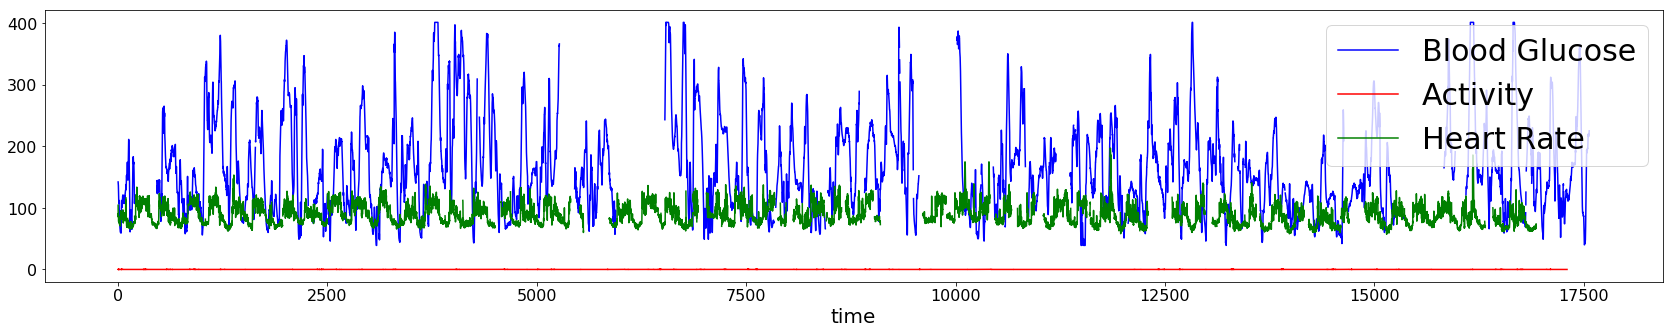

In [82]:
plt.figure(figsize=(29,5))
plt.plot(bg_proc['gluc'],'b')
plt.plot(da_proc['act'],'r')
plt.plot(hr_proc['hr'],'g')
plt.legend(['Blood Glucose','Activity','Heart Rate'],fontsize=30)
plt.xlabel('time')

In [9]:
#Merge dataframes into one 
da_proc.reset_index(inplace = True)
bg_proc.reset_index(inplace = True)
hr_proc.reset_index(inplace = True)
df_merge = bg_proc.merge(da_proc, how = 'left', left_on = 'time', right_on = 'time' )
df_merge = df_merge.merge(hr_proc, how = 'left', left_on = 'time', right_on = 'time')

### Observations: 
### There is missing data in all 3 time series. I can deal with these in the blood glucose time series by replacing NaN values with 0 and using masking layers in the neural network I will build. These will let the network know to ignore these values when training.
### The features are on very different scales. I will scale them using a MinMaxScaler later.
### Missing heart rates can be filled in with average values as a simple measure. Since the heart rate oscillates about a mean value throughout the entire data set this is not too unreasonable.
### Missing step counter data will be filled with 0s. I am assuming that when no activity data is being recorded the subject is more likely to be sleeping, showering, etc, than being active.

In [11]:
#gluc_mean = df_merge['gluc'].mean()
#act_mean = df_merge['act'].mean()
hr_mean = df_merge['hr'].mean()

df_merge['gluc'].fillna(0,inplace=True)
df_merge['act'].fillna(0,inplace=True)
df_merge['hr'].fillna(hr_mean,inplace=True)


## Tensorflow implementation

### I will be using a simple one layer LSTM network as a first try to get a sense of what a base model can do. The input to the LSTMs will be time series of length 30 * 5 minutes = 2.5 hours. My rationale here is that 2.5 hours is long enough to include any effects from fast acting insulin, exercise or carb intake on blood glucose. I assume that these are the main drivers of blood glucose changes.
### The input tensor of the network is of size (samples,timesteps, features) = (samples,30,3)
### The output of the network is a 12 * 5 minute = 60 minute prediction for each sample. The tensor size will be (samples,12)
### First, I will create a function that can extract all of the 2.5 hour intervals out of the data set and assign the labels appropriately.

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Masking
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-13):  #Needs 12 outputs
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[(i + look_back):(i+look_back+12), 0])
    return np.array(dataX), np.array(dataY)
# fix random seed for reproducibility
np.random.seed(7)


### Now I will use a MinMax Scaler to restrict the features to the range [0,1]. This ensures that no single feature is disproportionately weighted during gradient descent. 

In [ ]:
# load the dataset
dataset = df_merge['gluc'].values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.reshape(-1,1))

### Split the data set into training (67%) and test (33%) sets

In [13]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

look_back = 30 #Use 30 data points as time series length (2.5 hours)
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

### I will do the same for the heart rate and activity dataframes below.

In [14]:
dataset2 = df_merge['act'].values
dataset2 = dataset.astype('float32')
dataset3 = df_merge['hr'].values
dataset3 = dataset.astype('float32')
dataset2 = scaler.fit_transform(dataset.reshape(-1,1))
dataset3 = scaler.fit_transform(dataset.reshape(-1,1))

train2, test2 = dataset2[0:train_size,:], dataset2[train_size:len(dataset),:]

trainX2, trainY2 = create_dataset(train2, look_back)
testX2, testY2 = create_dataset(test2, look_back)

train3, test3 = dataset3[0:train_size,:], dataset3[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 30
trainX3, trainY3 = create_dataset(train3, look_back)
testX3, testY3 = create_dataset(test3, look_back)

### I have created 3 separate training sets but now I should stack them so that they can be inserted into the network all at once.

In [15]:
trainXstack = np.stack((trainX,trainX2,trainX3))
testXstack = np.stack((testX,testX2,testX3))

### Finally, I will build the model and ensure the shapes of my tensors make sense. I will use a masking layer to get the network to ignore missing data, and I arbitrarily use 12 LSTM modules in the second layer with a relu activation. These are fed into a dense layer which outputs the 12 predictions.

In [16]:
# reshape input to be [samples, time steps, features]
#trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1],1)) #only use 1 feature for now
#testX = np.reshape(testX, (testX.shape[0], testX.shape[1],1))

trainXstack = trainXstack.transpose([1,2,0])
testXstack = testXstack.transpose([1,2,0])

# create and fit the LSTM network
model3 = Sequential()
model3.add(Masking(mask_value=0))
model3.add(LSTM(12, input_shape=(look_back,3), activation = 'relu'))
model3.add(Dense(12))
model3.compile(loss='mean_squared_error', optimizer='adam')
model3.build(input_shape=np.shape(trainXstack))
model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (11727, 30, 3)            0         
_________________________________________________________________
lstm (LSTM)                  (11727, 12)               768       
_________________________________________________________________
dense (Dense)                (11727, 12)               156       
Total params: 924
Trainable params: 924
Non-trainable params: 0
_________________________________________________________________


### Fit the model over 50 epochs with early stopping on the validation data. I use a batch size of 5 to speed up the training process, with an early stopping mechanism so that we don't overfit the data.

In [17]:
from tensorflow.keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='val_loss', patience=4)
history3 = model3.fit(trainXstack, trainY, validation_data = (testXstack,testY),epochs=50, batch_size=5, verbose=2, callbacks = [callback])

Epoch 1/50
2346/2346 - 27s - loss: 0.0204 - val_loss: 0.0122
Epoch 2/50
2346/2346 - 26s - loss: 0.0141 - val_loss: 0.0106
Epoch 3/50
2346/2346 - 26s - loss: 0.0134 - val_loss: 0.0098
Epoch 4/50
2346/2346 - 26s - loss: 0.0129 - val_loss: 0.0091
Epoch 5/50
2346/2346 - 26s - loss: 0.0126 - val_loss: 0.0090
Epoch 6/50
2346/2346 - 26s - loss: 0.0123 - val_loss: 0.0090
Epoch 7/50
2346/2346 - 25s - loss: 0.0120 - val_loss: 0.0084
Epoch 8/50
2346/2346 - 24s - loss: 0.0120 - val_loss: 0.0087
Epoch 9/50
2346/2346 - 23s - loss: 0.0118 - val_loss: 0.0092
Epoch 10/50
2346/2346 - 24s - loss: 0.0117 - val_loss: 0.0083
Epoch 11/50
2346/2346 - 23s - loss: 0.0117 - val_loss: 0.0083
Epoch 12/50
2346/2346 - 23s - loss: 0.0115 - val_loss: 0.0084
Epoch 13/50
2346/2346 - 24s - loss: 0.0115 - val_loss: 0.0084
Epoch 14/50
2346/2346 - 24s - loss: 0.0116 - val_loss: 0.0081
Epoch 15/50
2346/2346 - 23s - loss: 0.0115 - val_loss: 0.0087
Epoch 16/50
2346/2346 - 23s - loss: 0.0114 - val_loss: 0.0081
Epoch 17/50
2346/

### Plot the model loss for the training and test sets

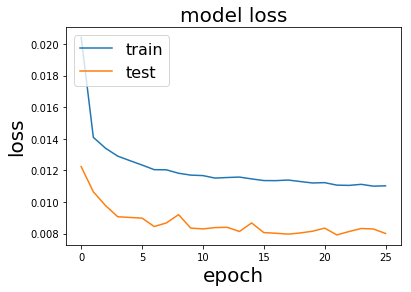

In [69]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss',fontsize = 20)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left',fontsize = 16)
plt.rc('axes', labelsize=20)     # fontsize of the axes title
plt.rc('xtick', labelsize=10)     # fontsize of the axes title
plt.rc('ytick', labelsize=10)     # fontsize of the axes title
plt.show()

### I calculate the RMSE below, not including points where missing labels were interpreted as 0. 

In [18]:
#save model
model3.save("BGsimple.h5")

# make predictions
trainPredict = model3.predict(trainXstack)
testPredict = model3.predict(testXstack)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict*(trainY>0)))
print('Train Score: %.3f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict*(testY>0)))
print('Test Score: %.3f RMSE' % (testScore))

Train Score: 0.079 RMSE
Test Score: 0.065 RMSE


### Finally let's look at a 60 minute prediction horizon from the training and test set.

Text(0.5, 1.0, '60 minute prediction horizon - test set')

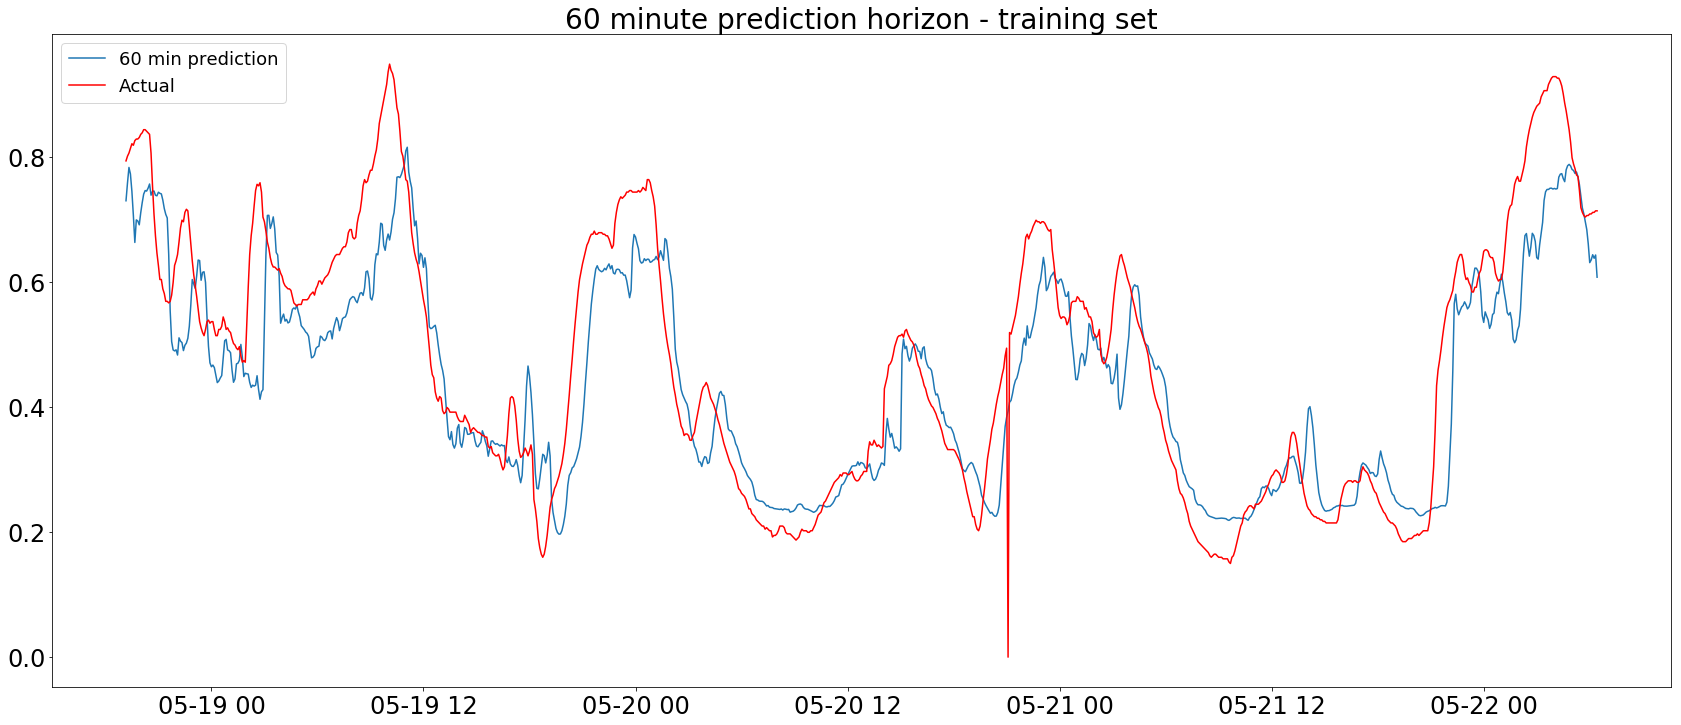

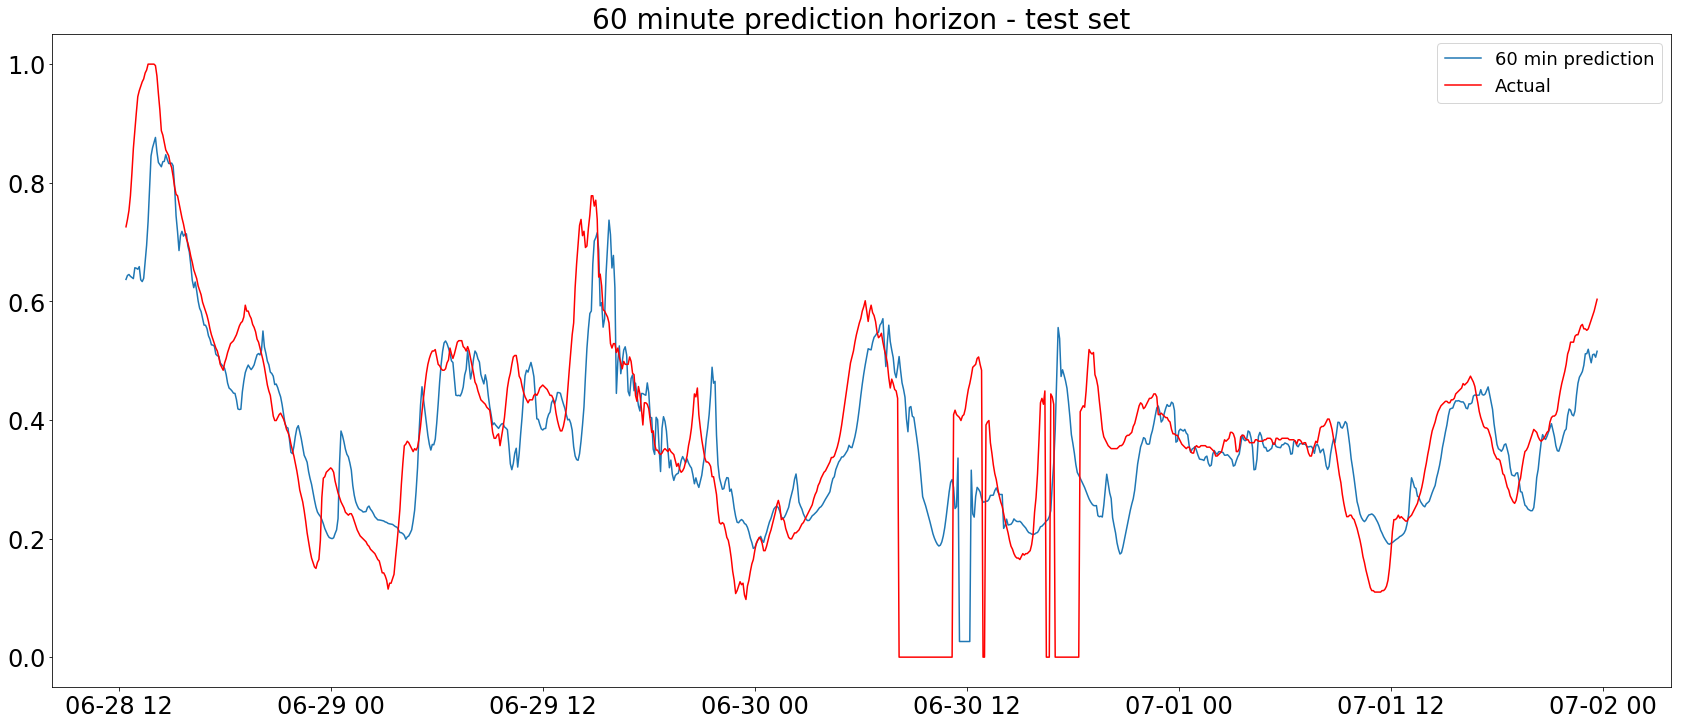

In [22]:
#Check some random plots
plt.figure(figsize=(29,12))
plt.plot(df_merge['time'].iloc[1000:2000],trainPredict[1000:2000,11])
plt.plot(df_merge['time'].iloc[1000:2000],trainY[1000:2000,11],'r')
plt.rc('xtick', labelsize=24)     # fontsize of the axes title
plt.rc('ytick', labelsize=24)     # fontsize of the axes title
plt.legend(['60 min prediction','Actual'],fontsize = 18)
plt.title('60 minute prediction horizon - training set',fontsize = 28)

plt.figure(figsize=(29,12))
plt.plot(df_merge['time'].iloc[trainXstack.shape[0]+1000:trainXstack.shape[0]+2000],testPredict[1000:2000,11])
plt.plot(df_merge['time'].iloc[trainXstack.shape[0]+1000:trainXstack.shape[0]+2000],testY[1000:2000,11],'r')
plt.rc('xtick', labelsize=24)     # fontsize of the axes title
plt.rc('ytick', labelsize=24)     # fontsize of the axes title
plt.legend(['60 min prediction','Actual'],fontsize = 18)
plt.title('60 minute prediction horizon - test set',fontsize = 28)


### The algorithm performs fairly well with an RSME of 0.065 on the data set. It seems to pick up on falling trends (see 06-29 after 12PM) but lags on upwards trends. Predictions near 06-30 at 12PM is very inaccurate because there was no data to pull from before 12PM.

### Let's refine this model now and see if we can improve.
### In the second refined algorithm I will feed each time series into their own LSTM module for processing before being concatenated into a dense layer. This idea is based off the work of Munoz-Organero in his paper "Deep Physiological Model for Blood Glucose Prediction in T1DM Patients".
### Conceptually, this allows the network to learn the dynamics of the time series independently first, and then apply this knowledge to predict blood glucose in the later layers.

In [26]:
from tensorflow.keras import Input
from tensorflow.keras import Model
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
import tensorflow.keras.backend as kb
from tensorflow.math import reduce_mean

bs = 5
mem_cells = 20
dense_cells = 12

opt = Adam(learning_rate=0.001)

input1 = Input(shape = (look_back, 1))

x10 = Masking(mask_value=0,input_shape=(look_back, 1))(input1)
x11 = LSTM(units = mem_cells, activation = 'relu', return_sequences=False)(x10)
x12 = Dense(units = dense_cells, activation = 'relu')
x1 = x12(x11)

input2 = Input(shape = (look_back,1))
x21 = LSTM(units = mem_cells, activation = 'relu', return_sequences = False)(input2)
x22 = Dense(units = dense_cells, activation = 'relu')
x2 = x22(x21)

input3 = Input(shape = (look_back, 1))
x31 = LSTM(units = mem_cells, activation = 'relu', return_sequences = False)(input3)
x32 = Dense(units = dense_cells, activation = 'relu')
x3 = x32(x31)
added = Concatenate(axis = -1)([x2, x3])
added2 = Concatenate(axis = -1)([x1, added])

out1 = Dense(12)(added2)
model2 = Model(inputs = [input1, input2, input3], outputs=out1)
model2.compile(loss = 'mean_squared_error', optimizer = opt)
model2.summary()
model2([trainX,trainX2,trainX3],trainY)

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 30, 1)]      0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 30, 1)]      0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 30, 1)]      0                                            
__________________________________________________________________________________________________
masking_2 (Masking)             (None, 30, 1)        0           input_4[0][0]                    
_______________________________________________________________________________________

<tf.Tensor: shape=(11727, 12), dtype=float32, numpy=
array([[-0.00047146,  0.02719796, -0.00644128, ...,  0.00335995,
         0.01130641,  0.03703487],
       [-0.00049221,  0.0279446 , -0.00660679, ...,  0.00327288,
         0.01191012,  0.03789217],
       [-0.00049775,  0.02859485, -0.0067461 , ...,  0.00324643,
         0.01240607,  0.03869351],
       ...,
       [-0.00035524,  0.08626173, -0.01994878, ...,  0.01239935,
         0.03415354,  0.11879034],
       [-0.00036836,  0.08201127, -0.01898228, ...,  0.0120367 ,
         0.03201921,  0.11309113],
       [-0.00038872,  0.0775558 , -0.0179698 , ...,  0.01158958,
         0.02988038,  0.10707805]], dtype=float32)>

In [27]:
#Reshape to (samples, time, features)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1],1)) 
testX = np.reshape(testX, (testX.shape[0], testX.shape[1],1))

trainX2 = np.reshape(trainX2, (trainX2.shape[0], trainX2.shape[1],1))
testX2 = np.reshape(testX2, (testX2.shape[0], testX2.shape[1],1))

trainX3 = np.reshape(trainX3, (trainX3.shape[0], trainX3.shape[1],1))
testX3 = np.reshape(testX3, (testX3.shape[0], testX3.shape[1],1))

### As before, I use early stopping and a batch size of 5 for training.

In [28]:
callback2 = EarlyStopping(monitor='val_loss', patience=4)
history2 = model2.fit([trainX,trainX2,trainX3],trainY,epochs = 50,batch_size = bs, validation_data = ([testX,testX2,testX3],testY),verbose=2, shuffle = False, callbacks = [callback2])

Epoch 1/50
2346/2346 - 49s - loss: 0.0187 - val_loss: 0.0090
Epoch 2/50
2346/2346 - 46s - loss: 0.0119 - val_loss: 0.0080
Epoch 3/50
2346/2346 - 46s - loss: 0.0103 - val_loss: 0.0075
Epoch 4/50
2346/2346 - 47s - loss: 0.0098 - val_loss: 0.0076
Epoch 5/50
2346/2346 - 47s - loss: 0.0095 - val_loss: 0.0072
Epoch 6/50
2346/2346 - 50s - loss: 0.0092 - val_loss: 0.0070
Epoch 7/50
2346/2346 - 49s - loss: 0.0090 - val_loss: 0.0069
Epoch 8/50
2346/2346 - 48s - loss: 0.0089 - val_loss: 0.0068
Epoch 9/50
2346/2346 - 49s - loss: 0.0088 - val_loss: 0.0067
Epoch 10/50
2346/2346 - 48s - loss: 0.0087 - val_loss: 0.0066
Epoch 11/50
2346/2346 - 49s - loss: 0.0086 - val_loss: 0.0065
Epoch 12/50
2346/2346 - 48s - loss: 0.0085 - val_loss: 0.0064
Epoch 13/50
2346/2346 - 47s - loss: 0.0085 - val_loss: 0.0066
Epoch 14/50
2346/2346 - 46s - loss: 0.0085 - val_loss: 0.0063
Epoch 15/50
2346/2346 - 46s - loss: 0.0084 - val_loss: 0.0064
Epoch 16/50
2346/2346 - 44s - loss: 0.0084 - val_loss: 0.0064
Epoch 17/50
2346/

## Plot the training and test loss 

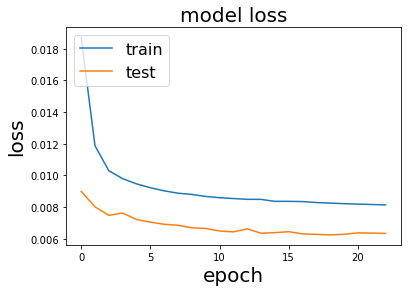

In [70]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss',fontsize = 20)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left',fontsize = 16)
plt.rc('axes', labelsize=20)     # fontsize of the axes title
plt.rc('xtick', labelsize=10)     # fontsize of the axes title
plt.rc('ytick', labelsize=10)     # fontsize of the axes title
plt.show()

## Calculate the RMSE score on the training and test sets.

In [39]:
# save model
model2.save("BGall.h5")

# make predictions
trainPredict = model2.predict([trainX,trainX2,trainX3])
testPredict = model2.predict([testX,testX2,testX3])
# invert predictions
#trainPredict = scaler.inverse_transform(trainPredict)
#trainY = scaler.inverse_transform([trainY])
#testPredict = scaler.inverse_transform(testPredict)
#testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict*(trainY>0)))
print('Train Score: %.3f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict*(testY>0)))
print('Test Score: %.3f RMSE' % (testScore))

Train Score: 0.071 RMSE
Test Score: 0.061 RMSE


### The RMSE has been improved by 10 and 6 % for the training set and test set, respectively!

## Plot some 10 and 60 minute prediction horizons for the training and test sets. A random sample of seven 60 minute predictions from the test set will be compared to ground truth here as well.

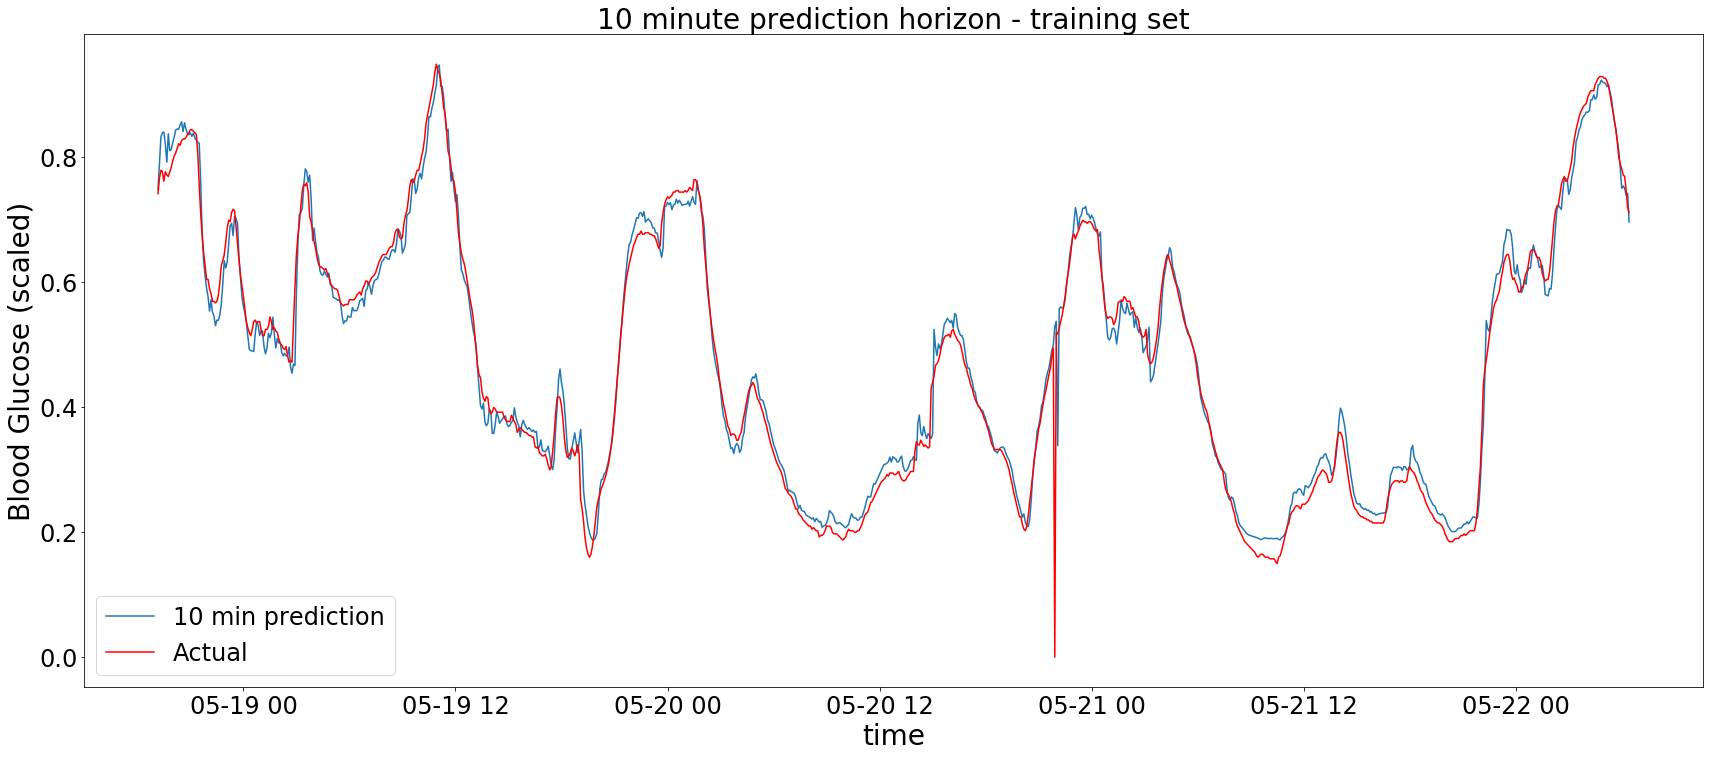

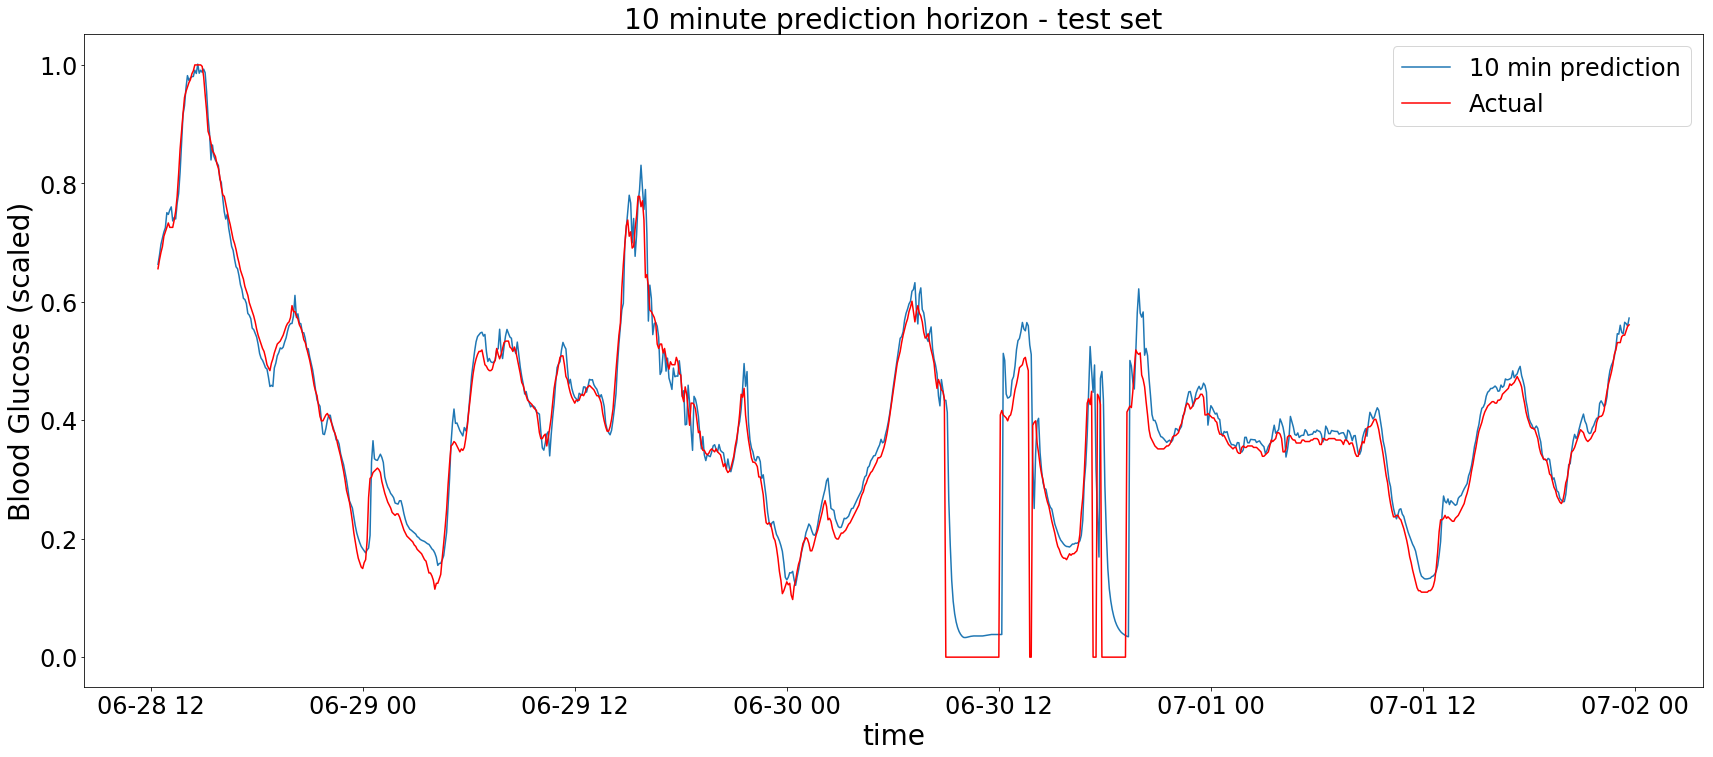

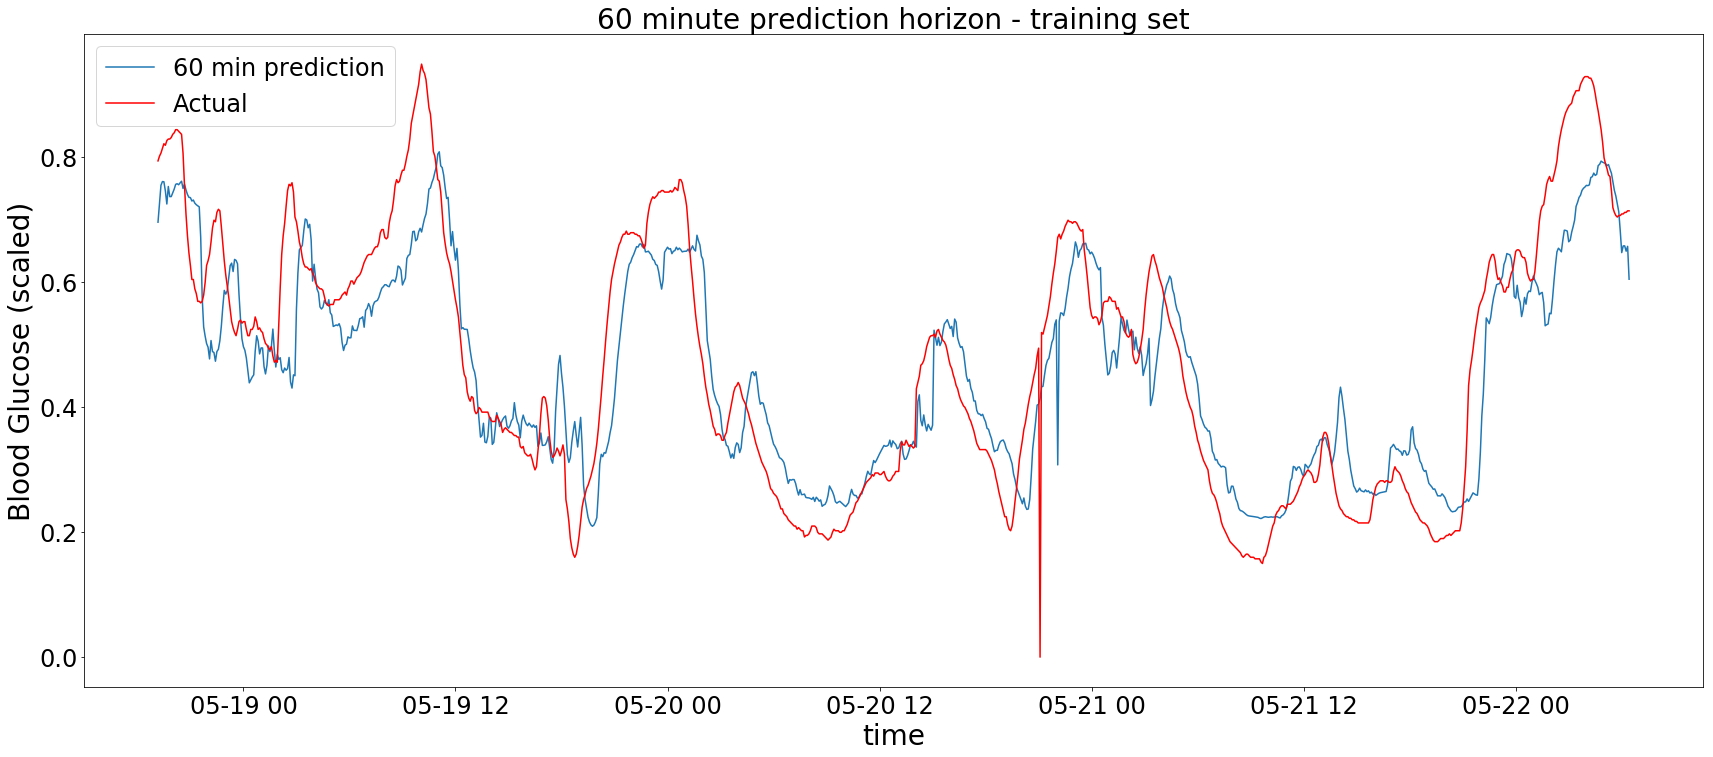

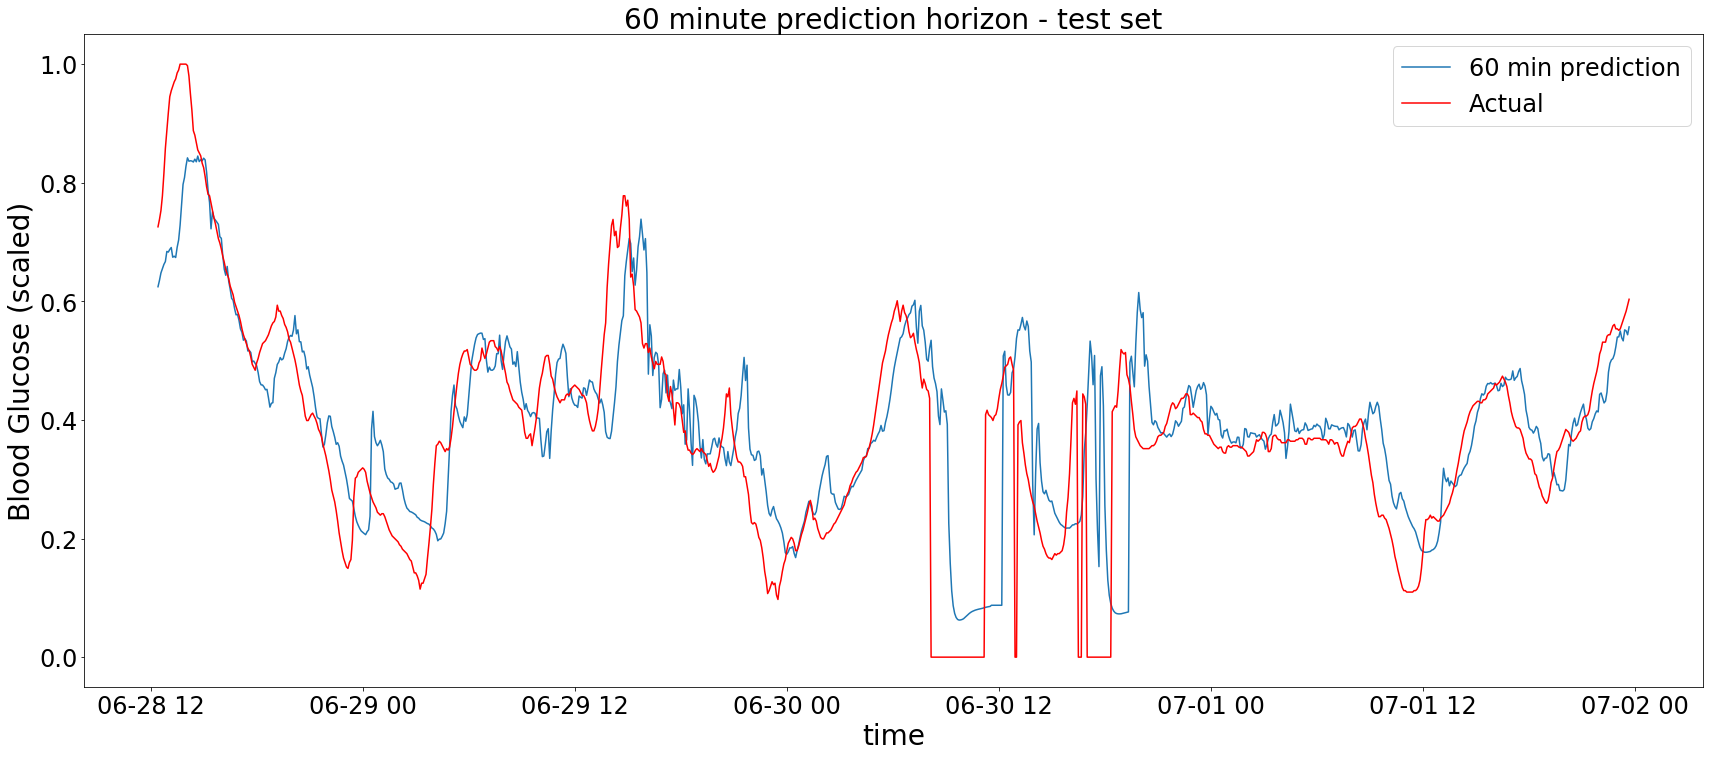

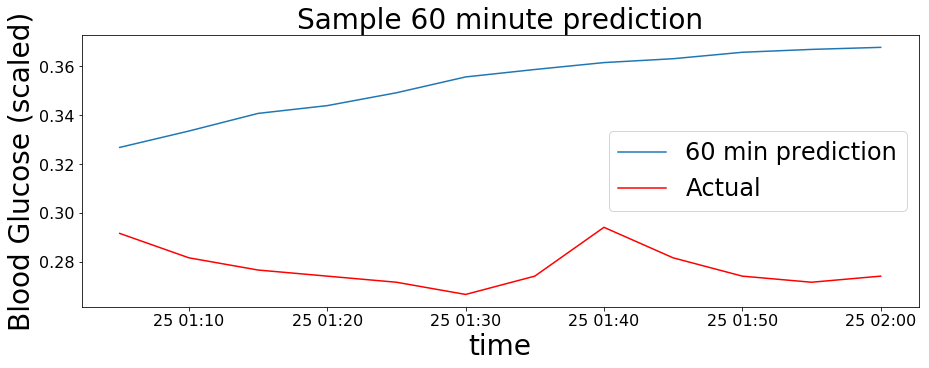

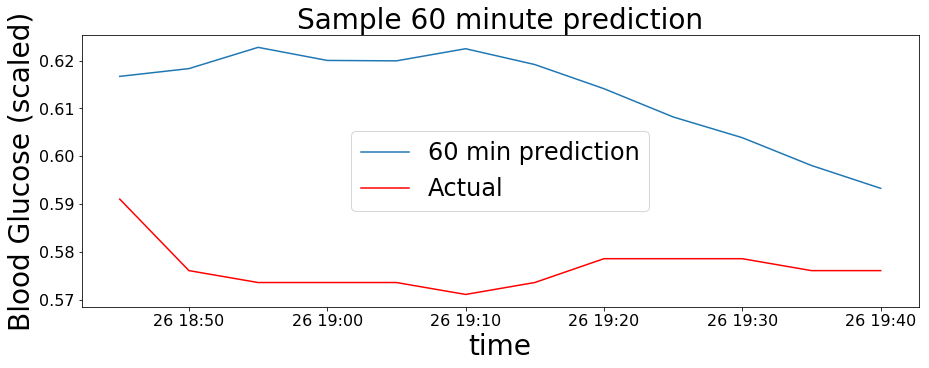

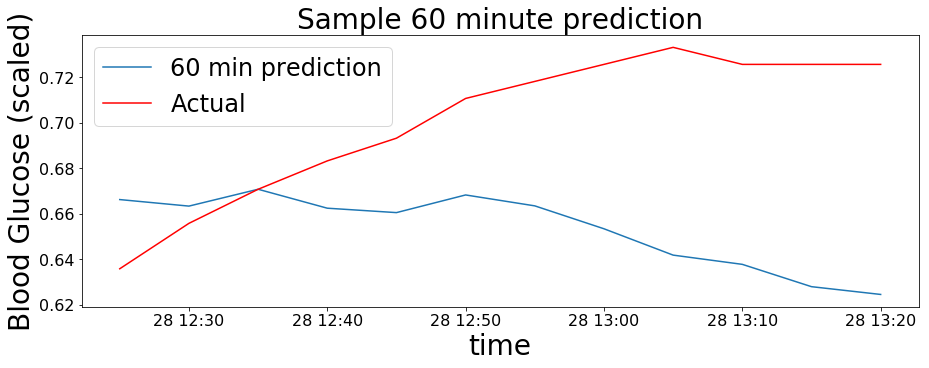

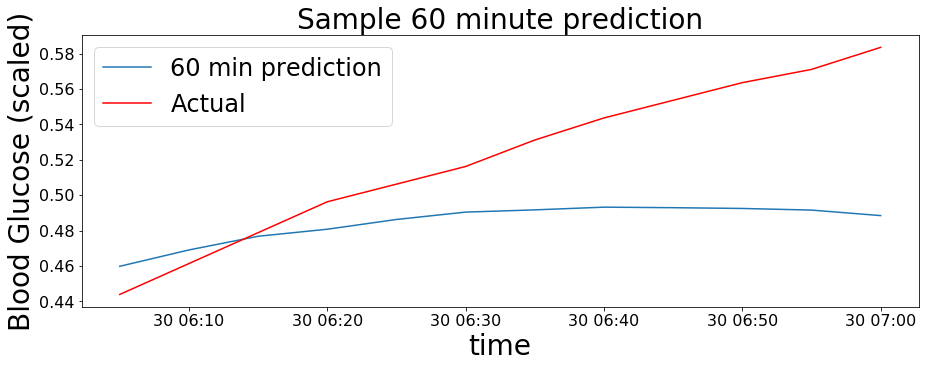

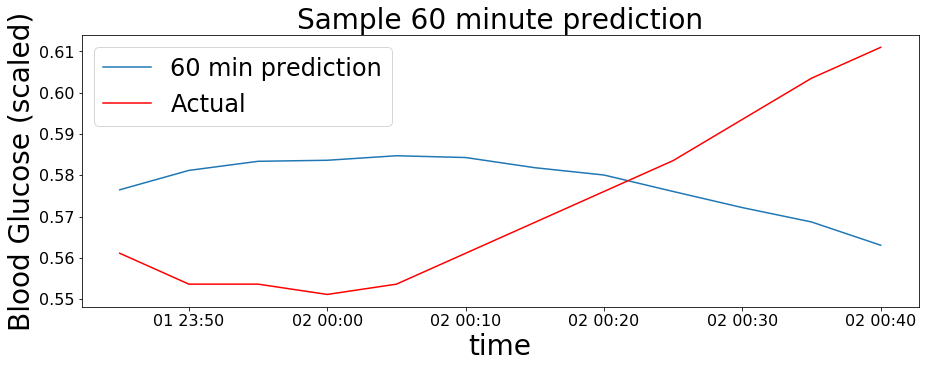

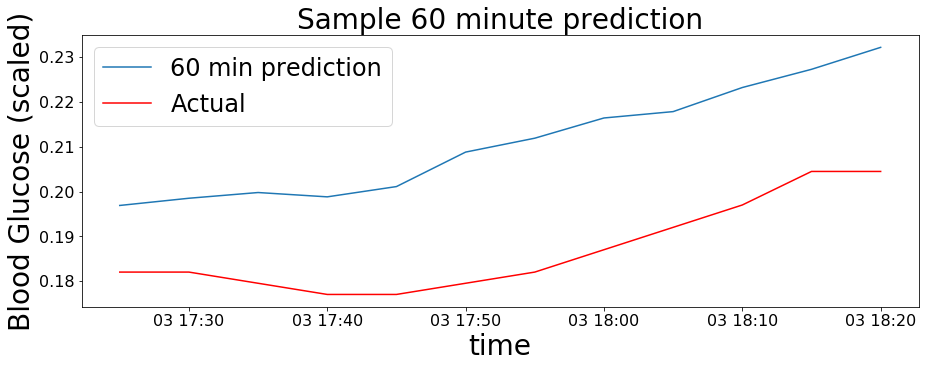

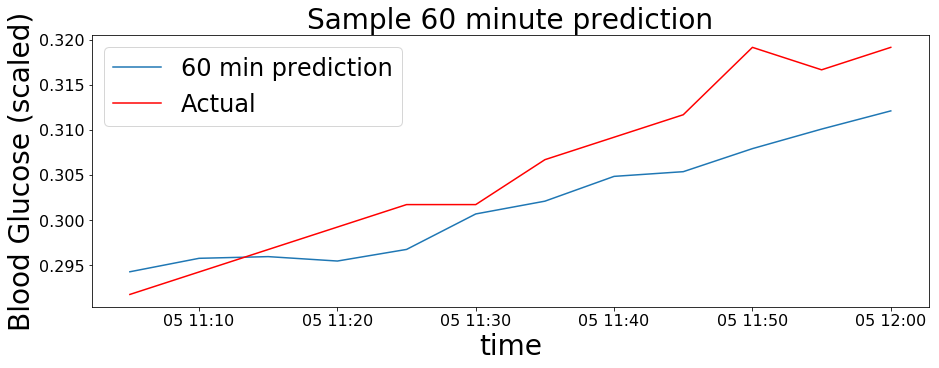

In [88]:
#Plot 10 minute prediction horizon for the training set
plt.rc('xtick', labelsize=24)     # fontsize of the axes title
plt.rc('ytick', labelsize=24)     # fontsize of the axes title
plt.figure(figsize=(29,12))
plt.plot(df_merge['time'].iloc[1000:2000],trainPredict[1000:2000,1])
plt.plot(df_merge['time'].iloc[1000:2000],trainY[1000:2000,1],'r')
plt.legend(['10 min prediction','Actual'],fontsize = 24)
plt.title('10 minute prediction horizon - training set',fontsize = 28)
plt.xlabel('time',fontsize = 28)
plt.ylabel('Blood Glucose (scaled)',fontsize = 28)

#Plot 10 minute prediction horizon for the test set
plt.figure(figsize=(29,12))
plt.plot(df_merge['time'].iloc[trainX.shape[0]+1000:trainX.shape[0]+2000],testPredict[1000:2000,1])
plt.plot(df_merge['time'].iloc[trainX.shape[0]+1000:trainX.shape[0]+2000],testY[1000:2000,1],'r')
plt.legend(['10 min prediction','Actual'],fontsize = 24)
plt.title('10 minute prediction horizon - test set',fontsize = 28)
plt.rc('xtick', labelsize=24)     # fontsize of the axes title
plt.rc('ytick', labelsize=24)     # fontsize of the axes title
plt.xlabel('time',fontsize = 28)
plt.ylabel('Blood Glucose (scaled)',fontsize = 28)

#Plot 60 minute prediction horizon for the training set
plt.figure(figsize=(29,12))
plt.plot(df_merge['time'].iloc[1000:2000],trainPredict[1000:2000,11])
plt.plot(df_merge['time'].iloc[1000:2000],trainY[1000:2000,11],'r')
plt.legend(['60 min prediction','Actual'],fontsize = 24)
plt.title('60 minute prediction horizon - training set',fontsize = 28)
plt.xlabel('time',fontsize = 28)
plt.ylabel('Blood Glucose (scaled)',fontsize = 28)

#Plot 60 minute prediction horizon for the test set
plt.figure(figsize=(29,12))
plt.plot(df_merge['time'].iloc[trainX.shape[0]+1000:trainX.shape[0]+2000],testPredict[1000:2000,11])
plt.plot(df_merge['time'].iloc[trainX.shape[0]+1000:trainX.shape[0]+2000],testY[1000:2000,11],'r')
plt.legend(['60 min prediction','Actual'],fontsize = 24)
plt.title('60 minute prediction horizon - test set',fontsize = 28)
plt.rc('xtick', labelsize=16)     # fontsize of the axes title
plt.rc('ytick', labelsize=16)     # fontsize of the axes title
plt.xlabel('time',fontsize = 28)
plt.ylabel('Blood Glucose (scaled)',fontsize = 28)

for i in range(0,7):
    plt.rc('xtick', labelsize=16)     # fontsize of the axes title
    plt.rc('ytick', labelsize=16)     # fontsize of the axes title
    plt.figure(figsize=(15,5))
    plt.plot(df_merge['time'].iloc[trainX.shape[0]+500*i:trainX.shape[0]+500*i+12],testPredict[500*i,:])
    plt.plot(df_merge['time'].iloc[trainX.shape[0]+500*i:trainX.shape[0]+500*i+12],testY[500*i,:],'r')
    #plt.ylim((0, 1))
    plt.title('Sample 60 minute prediction',fontsize = 28)
    plt.legend(['60 min prediction','Actual'],fontsize = 24)
    plt.xlabel('time',fontsize = 28)
    plt.ylabel('Blood Glucose (scaled)',fontsize = 28)

### Comparing the 10 minute and 60 minute prediction horizon, we see the algorithm generally gets more inaccurate over time. This is unfortunately common to all forecasting problems.

### Note the scales on the y-axis are changing for each sample plot. Generally it can be seen that the predictions are within 10% of the actual values throughout each prediction period.

### Finally, I invert the scaling of the blood glucose and plot the prediction horizons again, so that they can be examined in units of mg/dL.

Text(0, 0.5, 'Blood Glucose (mg/dL)')

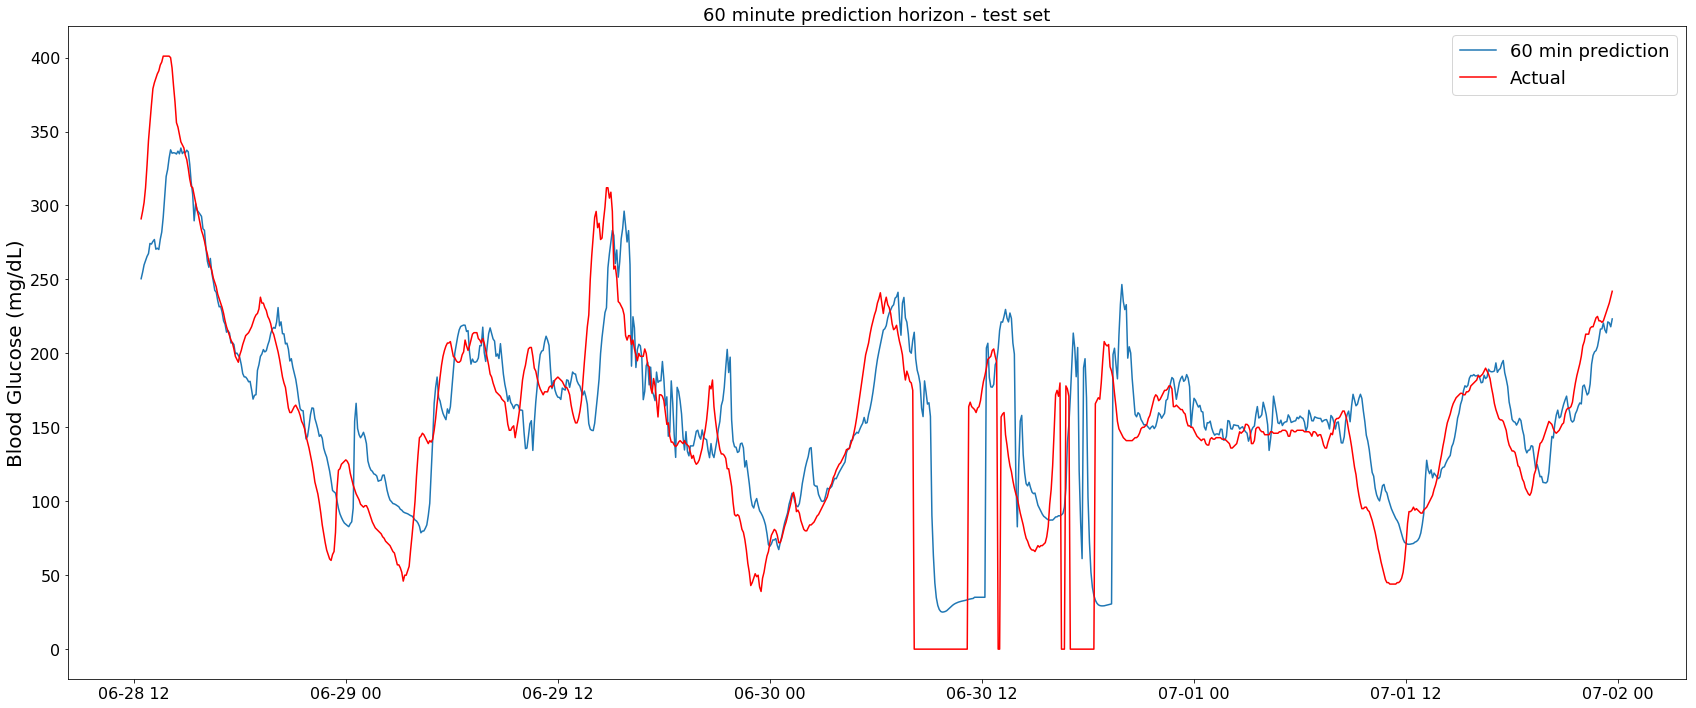

In [66]:
#dataset = df_merge['gluc'].values
#dataset = dataset.astype('float32')
#dataset = scaler.fit_transform(dataset.reshape(-1,1))
testPredict_rescaled = scaler.inverse_transform(testPredict)
testY_rescaled= scaler.inverse_transform(testY)

plt.figure(figsize=(29,12))
plt.plot(df_merge['time'].iloc[trainX.shape[0]+1000:trainX.shape[0]+2000],testPredict_rescaled[1000:2000,11])
plt.plot(df_merge['time'].iloc[trainX.shape[0]+1000:trainX.shape[0]+2000],testY_rescaled[1000:2000,11],'r')
plt.legend(['60 min prediction','Actual'],fontsize = 18)
plt.title('60 minute prediction horizon - test set',fontsize = 18)
plt.rc('xtick', labelsize=16)     # fontsize of the axes title
plt.rc('ytick', labelsize=16)     # fontsize of the axes title
plt.ylabel('Blood Glucose (mg/dL)')

### Finally I convert the RMSE scores from earlier to units of mg/dL in order to compare to other models. For reference, Kim et al used an LSTM network and reported RMSE values ranging between approximately (20-50) mg/dL in 2019[1] . 


[1] Kim et al. Blood Glucose Prediction for Type 2 Diabetic Patients Using Machine Learning. Diabetes 2019 Jun; 68(Supplement 1)

In [76]:
print("RMSE of training set in mg/DL:", scaler.inverse_transform(np.array(0.071).reshape(-1,1))[0][0])
print("RMSE of test set in mg/DL:", scaler.inverse_transform(np.array(0.061).reshape(-1,1))[0][0])

RMSE of training set in mg/DL: 28.470999032177527
RMSE of test set in mg/DL: 24.460999168490552


## Conclusion: The algorithm has a good RMSE score for the 60 minute horizons. Increasing and decreasing the number of layers/neurons has little effect on the final accuracy of the algorithm. This suggests that prediction accuracy could be improved mainly by data preprocessing or feature engineering.

### Future work: Some additional ideas that might be worth exploring involve the pharmacokinetics of insulin, carb intake, and blood glucose. We know that a certain level of carbs/insulin will spike or lower blood glucose proportionally. While this data is not directly available here, examining the first and second order derivatives of the blood glucose may allow us to infer some of these characteristics. These features will be sensitive to noise, however, and may require additional smoothing before application.